### 1. 导入相关库

In [1]:
import os  # 导入操作系统相关功能，用于路径拼接、获取当前目录等
import pandas as pd  # 导入pandas库，常用于表格数据处理，简写为pd
import numpy as np  # 导入numpy库，进行科学计算，简写为np
import tensorflow as tf  # 导入TensorFlow深度学习框架
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
# 导入Keras的图片数据增强器
from tensorflow.keras import layers, models, optimizers  
# 导入Keras的网络层、模型、优化器
import matplotlib.pyplot as plt  
# 导入matplotlib的绘图模块，简写为plt
import math # 用于计算ceil，确保steps_per_epoch完整

2025-06-15 12:09:37.710453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 12:09:37.726105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 12:09:37.745559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 12:09:37.751350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 12:09:37.765598: I tensorflow/core/platform/cpu_feature_guar

### 2. 路径和超参数设置

In [2]:
BASE_DIR = './'  # 定义项目的根目录为当前目录
# 拼接出训练集csv的完整路径
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')  
# 拼接出测试集csv的完整路径
TEST_CSV_PATH = os.path.join(BASE_DIR, 'test.csv')  

#### 2.1 图像参数

In [3]:
# 设置图片宽度和高度为150像素
IMAGE_WIDTH, IMAGE_HEIGHT = 150, 150  
# 组合成一个元组，方便后续调用
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) 
# 设置图片通道数为3，代表彩色图片
CHANNELS = 3 # RGB color images  

#### 2.2 训练超参数并打印

In [4]:
BATCH_SIZE = 32  # 每批处理32张图片
EPOCHS = 30   # 训练总轮数为30
LEARNING_RATE = 0.001   # 优化器的学习率设为0.001
# 打印提示信息
print("--- Path and Hyperparameters Setup Complete ---")  
print(f"Data Directory: {BASE_DIR}")  # 打印数据目录
print(f"Train CSV Path: {TRAIN_CSV_PATH}")  # 打印训练集csv路径
print(f"Test CSV Path: {TEST_CSV_PATH}")  # 打印测试集csv路径
print(f"Image Size: {IMAGE_SIZE}, Channels: {CHANNELS}")  # 打印图片大小和通道数
# 打印批大小、轮数、学习率
print(f"Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}, Learning Rate: {LEARNING_RATE}")  

--- Path and Hyperparameters Setup Complete ---
Data Directory: ./
Train CSV Path: ./train.csv
Test CSV Path: ./test.csv
Image Size: (150, 150), Channels: 3
Batch Size: 32, Epochs: 30, Learning Rate: 0.001


#### 2.3 加载数据，检测数据是否正确导入

In [5]:
print("\n--- Loading CSV Files ---")  # 提示开始加载csv文件
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)  # 用pandas读取训练csv为DataFrame
    test_df = pd.read_csv(TEST_CSV_PATH)  # 用pandas读取测试csv为DataFrame
    # 打印训练集样本数
    print(f"Successfully loaded training set, number of samples: {len(train_df)}")  
    # 打印测试集样本数
    print(f"Successfully loaded test set, number of samples: {len(test_df)}")  
    # Print a preview of 
    # the training set to confirm 'image' and 'label' columns are correct
    print("\nTraining Data Preview:")  # 打印训练集预览
    print(train_df.head())  # 显示训练集前五行
    print("\nTest Data Preview:")  # 打印测试集预览
    print(test_df.head())  # 显示测试集前五行
except FileNotFoundError as e:  # 如果文件没找到
    # 输出错误信息
    print(f"Error: CSV file not found. Please check the path. Error message: {e}")  
    # 打印期望的训练集路径
    print(f"Expected train.csv path: {os.path.abspath(TRAIN_CSV_PATH)}")  
    # 打印期望的测试集路径
    print(f"Expected test.csv path: {os.path.abspath(TEST_CSV_PATH)}")  
    exit() # Exit if file not found  # 直接退出程序


--- Loading CSV Files ---
Successfully loaded training set, number of samples: 18353
Successfully loaded test set, number of samples: 8800

Training Data Preview:
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera

Test Data Preview:
              image
0  images/18353.jpg
1  images/18354.jpg
2  images/18355.jpg
3  images/18356.jpg
4  images/18357.jpg


#### 2.4 图片路径拼接和数据增强

In [8]:
# 提示开始数据增强配置
print("\n--- Setting up ImageDataGenerators for data preprocessing and augmentation ---")  
# --- 新增代码：为图片路径创建绝对路径 ---
# 确保在 ImageDataGenerator.flow_from_dataframe 之前完成
# 获取当前脚本的实际工作目录
current_working_directory = os.getcwd() 
# 打印当前工作目录
print(f"\n当前工作目录 (CWD): {current_working_directory}")  

# 如果 BASE_DIR 是 './'，那么 os.path.join(current_working_directory, BASE_DIR) 实际上就是 CWD
# 因此，图片的绝对路径应该是 os.path.join(current_working_directory, image_path_from_csv)
train_df['image_full_path'] = train_df['image'].apply(lambda x: os.path.join(current_working_directory, x))  # 训练集图片绝对路径
test_df['image_full_path'] = test_df['image'].apply(lambda x: os.path.join(current_working_directory, x))  # 测试集图片绝对路径

print("\n图片完整路径预览 (train_df):")  # 打印训练集图片路径
print(train_df[['image', 'image_full_path']].head())  # 显示前五条图片路径

# Training data generator configuration: includes data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # 像素值缩放到0-1
    validation_split=0.2,           # 训练集按8:2拆分，20%做验证
    rotation_range=30,              # 随机旋转0~30度
    width_shift_range=0.2,          # 图片宽度方向随机平移20%
    height_shift_range=0.2,         # 图片高度方向随机平移20%
    shear_range=0.2,                # 剪切变换强度
    zoom_range=0.2,                 # 随机缩放范围
    horizontal_flip=True,           # 随机水平翻转
    fill_mode='nearest'             # 新增像素的填充值方式
)


--- Setting up ImageDataGenerators for data preprocessing and augmentation ---

当前工作目录 (CWD): /workspace/b24011208_聂依萍_树叶分类/classify-leaves

图片完整路径预览 (train_df):
          image                                    image_full_path
0  images/0.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
1  images/1.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
2  images/2.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
3  images/3.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
4  images/4.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...


### 3. 训练集生成器

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)  # 测试/验证集只做归一化

# 创建训练集生成器
# 目录：图像文件的根目录。由于 CSV 中的 “image” 列是 “images/0.jpg”,
# 并且 “images” 文件夹位于 “BASE_DIR” 中，因此将其设置为 BASE_DIR (即 “.’”)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,  # 输入数据表
    directory=BASE_DIR,  # 文件根目录
    x_col='image',  # 图片路径列
    y_col='label',  # 标签列
    target_size=IMAGE_SIZE,  # 图片缩放到指定大小
    batch_size=BATCH_SIZE,  # 每批图片数量
    class_mode='categorical',  # 多分类，标签独热编码
    subset='training',  # 只生成训练集部分
    shuffle=True,  # 数据顺序打乱
    color_mode='rgb'  # 彩色图片
) 

Found 13488 validated image filenames belonging to 176 classes.


/root/miniforge3/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1493 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


### 4. 验证集生成器

In [10]:
# Create validation set generator
validation_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,  # 输入数据表
    directory=BASE_DIR,  # 文件根目录
    x_col='image',  # 图片路径列
    y_col='label',  # 标签列
    target_size=IMAGE_SIZE,  # 图片缩放到指定大小
    batch_size=BATCH_SIZE,  # 每批图片数量
    class_mode='categorical',  # 多分类，标签独热编码
    subset='validation',  # 只生成验证集部分
    shuffle=False,  # 不打乱顺序
    color_mode='rgb'  # 彩色图片
)

Found 3372 validated image filenames belonging to 176 classes.


/root/miniforge3/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1493 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


### 5. 测试集生成器，打印信息

In [12]:
# Create test set generator (for prediction, no labels)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # 测试集数据表
    directory=BASE_DIR,  # 文件根目录
    x_col='image',  # 图片路径列
    y_col=None,  # 无标签
    target_size=IMAGE_SIZE,  # 缩放图片
    batch_size=BATCH_SIZE,  # 每批图片数量
    class_mode=None,  # 无标签模式
    shuffle=False,  # 顺序不打乱
    color_mode='rgb'  # 彩色图片
)

print("\n--- ImageDataGenerators Created Successfully ---")  # 打印提示
# Print the number of images and classes found by the generators, crucial for checking data loading
print(f"Training Generator: Found {train_gen.samples} images belonging to {len(train_gen.class_indices)} classes.")  # 训练集图片和类别数
print(f"Validation Generator: Found {validation_gen.samples} images belonging to {len(validation_gen.class_indices)} classes.")  # 验证集图片和类别数
print(f"Test Generator: Found {test_gen.samples} images.")  # 测试集图片数

Found 8800 validated image filenames.

--- ImageDataGenerators Created Successfully ---
Training Generator: Found 13488 images belonging to 176 classes.
Validation Generator: Found 3372 images belonging to 176 classes.
Test Generator: Found 8800 images.


### 6. 类别数量检测

In [14]:
# 检查是否成功找到图像和类
# 检查训练集图片或类别数是否为0
if train_gen.samples == 0 or len(train_gen.class_indices) == 0:  
    print("Error: Training set generator found no images or classes.  Please check BASE_DIR and image paths in CSV.")  # 打印错误
    exit()  # 退出程序

num_classes = len(train_gen.class_indices)  # 统计类别数
print(f"Number of classes for model output layer: {num_classes}")  # 打印类别数

Number of classes for model output layer: 176


#### 6.1 类别索引映射

In [15]:
# 获取从 class name 到 index 的映射 (用于后续的映射预测结果)
# train_gen.class_indices 是一个字典
# 例如 {‘class_name_A’: 0,‘class_name_B’: 1,...}
# 我们需要一个从 index 到 class name 的映射来预测结果
# 索引到类别名的反向映射表
idx_to_label = dict((v,k) for k,v in train_gen.class_indices.items())  

### 7. 构建CNN模型

In [16]:
print("\n--- Building CNN Model ---")  # 打印提示
model = models.Sequential([  # 初始化顺序模型
    # 第一组卷积层和池化层
    # # 卷积层，32个3x3卷积核，激活函数relu，指定输入尺寸
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)),  
    layers.MaxPooling2D(2, 2),  # 最大池化，2x2

    # 第二组卷积层和池化层
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层，64个3x3卷积核
    layers.MaxPooling2D(2, 2),  # 最大池化，2x2

    # 第三组卷积层和池化层
    layers.Conv2D(128, (3, 3), activation='relu'),  # 卷积层，128个3x3卷积核
    layers.MaxPooling2D(2, 2),  # 最大池化，2x2

    # 第四组卷积层和池化层
    layers.Conv2D(256, (3, 3), activation='relu'),  # 卷积层，256个3x3卷积核
    layers.MaxPooling2D(2, 2),  # 最大池化，2x2

    # 展平层，将 2D 特征图转换为 1D 向量
    layers.Flatten(),  # 拉平成一维向量

    # 全连接层
    layers.Dense(512, activation='relu'), # 全连接层，512个神经元
    layers.Dropout(0.5), # Dropout层，防止过拟合，随机舍弃50%神经元

    # 输出层：神经元数量等于类别数量，使用 softmax 激活进行多类别分类
    layers.Dense(num_classes, activation='softmax')  # 输出层，类别数个神经元，softmax多分类
])


--- Building CNN Model ---


/root/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749990690.448576   37546 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-15 12:31:30.505241: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

#### 7.1 模型编译与结构打印

In [17]:
# 编译模型：定义优化器、损失函数和评估指标
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),  # 使用Adam优化器
              loss='categorical_crossentropy', # 多分类交叉熵损失函数
              metrics=['accuracy'])  # 评价指标为准确率

print("\nCNN Model Summary:")  # 打印模型结构
model.summary()  # 展示模型各层结构参数


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 176)            │        90,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,901,744 (26.33 MB)

 Trainable params: 6,901,744 (26.33 MB)

 Non-trainable params: 0 (0.00 B)

##### 表格内容说明
Layer (type)：层的名称和类型（如Conv2D卷积层、MaxPooling2D池化层、Dense全连接层、Dropout等）。
Output Shape：该层输出的张量形状。None表示batch size不固定，后面的数字分别代表输出的高、宽和通道数（或神经元数）。
Param #：该层的参数个数（可训练参数数量）。
##### 模型结构分解如下
conv2d (Conv2D)

卷积层，输出形状: (None, 148, 148, 32)
意味着输入图片经过这层后，变成148x148大小、32个通道
参数数量：896（代表卷积核的权重和偏置）
max_pooling2d (MaxPooling2D)

池化层，输出形状: (None, 74, 74, 32)
池化层没有参数，只做降采样
conv2d_1 (Conv2D)

第二个卷积层，输出: (None, 72, 72, 64)
参数数量：18,496
max_pooling2d_1 (MaxPooling2D)

第二个池化层，输出: (None, 36, 36, 64)
无参数
conv2d_2 (Conv2D)

第三个卷积层，输出: (None, 34, 34, 128)
参数数量：73,856
max_pooling2d_2 (MaxPooling2D)

第三个池化层，输出: (None, 17, 17, 128)
无参数
conv2d_3 (Conv2D)

第四个卷积层，输出: (None, 15, 15, 256)
参数数量：295,168
max_pooling2d_3 (MaxPooling2D)

第四个池化层，输出: (None, 7, 7, 256)
无参数
flatten (Flatten)

拉平操作，把上一步输出展平成一维向量（77256=12544）
dense (Dense)

全连接层，512个神经元
参数数量：6,423,040（非常多，因为输入有12544个特征）
dropout (Dropout)

Dropout层，用于防止过拟合，没有参数
dense_1 (Dense)

输出层，176个神经元（对应176个类别）
参数数量：90,288

#### 7.2 图片加载测试

In [18]:
# --- 调试：手动加载图片以检查损坏 ---
print("\n--- 正在手动测试图片加载，请注意潜在的错误 ---")  # 提示开始测试图片加载
num_test_images = 10 # 尝试加载前10张图片
for i in range(min(num_test_images, len(train_df))):  # 只测试前10张
    image_relative_path = train_df.iloc[i]['image']  # 取图片相对路径
    image_full_path = os.path.join(BASE_DIR, image_relative_path)  # 拼接成完整路径
    try:
        # 使用 Pillow 直接加载图片
        from PIL import Image  # 导入Pillow库
        with Image.open(image_full_path) as img:  # 打开图片
            img.verify() # 验证图片完整性，但不会完全加载
            print(f"图片 {image_relative_path} 加载成功 (PIL.Image.open)。")  # 加载成功
    except Exception as e:
        print(f"错误: 图片 {image_relative_path} 加载失败或损坏。错误信息: {e}")  # 捕捉异常并打印
        print(f"请检查此文件: {image_full_path}")  # 打印出错图片路径
        # 遇到损坏图片后停止，您可以继续迭代或退出
        # break # 如果想在发现第一个损坏图片后停止
print("--- 图片加载测试完成 ---")  # 全部测试完毕


--- 正在手动测试图片加载，请注意潜在的错误 ---
图片 images/0.jpg 加载成功 (PIL.Image.open)。
图片 images/1.jpg 加载成功 (PIL.Image.open)。
图片 images/2.jpg 加载成功 (PIL.Image.open)。
图片 images/3.jpg 加载成功 (PIL.Image.open)。
图片 images/4.jpg 加载成功 (PIL.Image.open)。
图片 images/5.jpg 加载成功 (PIL.Image.open)。
图片 images/6.jpg 加载成功 (PIL.Image.open)。
图片 images/7.jpg 加载成功 (PIL.Image.open)。
图片 images/8.jpg 加载成功 (PIL.Image.open)。
图片 images/9.jpg 加载成功 (PIL.Image.open)。
--- 图片加载测试完成 ---


### 8. 模型训练

In [20]:
print("\n--- Starting Model Training ---")  # 打印训练开始提示

# 计算每个轮次的训练和验证步骤
# math.ceil 确保即使是不完整的最后批次也能得到处理
steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)  # 训练集每轮步数，向上取整
validation_steps = math.ceil(validation_gen.samples / BATCH_SIZE)  # 验证集每轮步数，向上取整

print(f"Training steps per Epoch: {steps_per_epoch}")  # 打印训练步数
print(f"Validation steps per Epoch: {validation_steps}")  # 打印验证步数

try:   
    history = model.fit(
        train_gen,                        # 训练数据生成器
        steps_per_epoch=steps_per_epoch,  # 每轮训练步数
        epochs=EPOCHS,                    # 总轮数
        validation_data=validation_gen,   # 验证数据生成器
        validation_steps=validation_steps # 每轮验证步数
    )
    print("\nModel training completed.")  # 训练完成
except Exception as e:
    print(f"Error during model training: {e}")  # 训练出错
    print("Please check if your resources (RAM/GPU VRAM) are sufficient, or try reducing BATCH_SIZE.")  # 资源不足提示
    exit()  # 退出


--- Starting Model Training ---
Training steps per Epoch: 422
Validation steps per Epoch: 106


/root/miniforge3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 128s 298ms/step - accuracy: 0.0123 - loss: 5.1160 - val_accuracy: 0.0555 - val_loss: 4.5569
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 297ms/step - accuracy: 0.0373 - loss: 4.5690 - val_accuracy: 0.0813 - val_loss: 4.0900
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 126s 298ms/step - accuracy: 0.0580 - loss: 4.1740 - val_accuracy: 0.1254 - val_loss: 3.7171
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 297ms/step - accuracy: 0.0857 - loss: 3.8727 - val_accuracy: 0.1474 - val_loss: 3.4563
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 126s 298ms/step - accuracy: 0.1092 - loss: 3.6300 - val_accuracy: 0.1848 - val_loss: 3.2760
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 297ms/step - accuracy: 0.1363 - loss: 3.4420 - val_accuracy: 0.2307 - val_loss: 3.0284
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 126s 298ms/step - accuracy: 0.1750 - loss: 3.2407 - val_accuracy: 0.2355 - val_loss: 2.9487
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 126s 297ms/step - accuracy: 0.1985 -

### 9. 训练过程可视化


--- Visualizing Training Progress ---


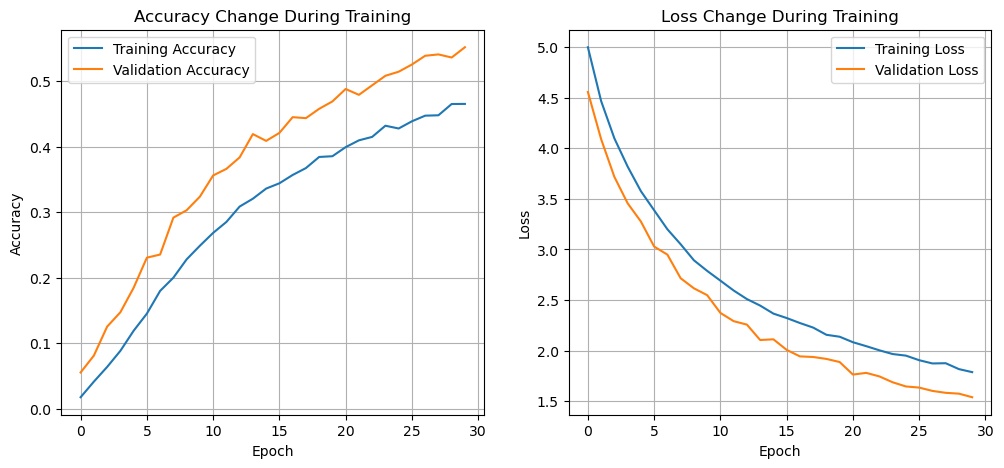

In [21]:
print("\n--- Visualizing Training Progress ---")  # 打印可视化提示
# 训练和验证的准确率曲线
plt.figure(figsize=(12, 5))  # 创建12x5的画布
plt.subplot(1, 2, 1)  # 第1个子图
plt.plot(history.history['accuracy'], label='Training Accuracy')  # 绘制训练准确率
if 'val_accuracy' in history.history: # Ensure validation accuracy exists
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # 绘制验证准确率
plt.title('Accuracy Change During Training')  # 标题
plt.xlabel('Epoch')  # 横坐标
plt.ylabel('Accuracy')  # 纵坐标
plt.legend()  # 图例
plt.grid(True)  # 网格

# 损失变化曲线
plt.subplot(1, 2, 2)  # 第2个子图
plt.plot(history.history['loss'], label='Training Loss')  # 绘制训练损失
if 'val_loss' in history.history: # Ensure validation loss exists
    plt.plot(history.history['val_loss'], label='Validation Loss')  # 绘制验证损失
plt.title('Loss Change During Training')  # 标题
plt.xlabel('Epoch')  # 横坐标
plt.ylabel('Loss')  # 纵坐标
plt.legend()  # 图例
plt.grid(True)  # 网格
plt.show()  # 显示图像

### 10. 模型预测

In [22]:
print("\n--- Performing Predictions on Test Set ---")  # 打印预测提示

# Calculate test steps
test_steps = math.ceil(test_gen.samples / BATCH_SIZE)  # 测试集总步数，向上取整

try:
    # Perform prediction
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)  # 预测所有测试图片
    # 使用训练好的模型对测试数据生成器中的图像进行预测，确保覆盖所有测似样本
    #获取每个样本的预测类别索引（概率最高的那个）
    predicted_class_indices = np.argmax(predictions, axis=1)  # 取概率最高的类别索引

    # 将预测的索引映射回原始类别名称
    predicted_labels = [idx_to_label[idx] for idx in predicted_class_indices]  # 转换为类别名

    print("\nPrediction completed.")  # 完成提示

except Exception as e:
    print(f"Error during prediction: {e}")  # 打印错误
    exit()  # 退出


--- Performing Predictions on Test Set ---
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step

Prediction completed.


### 11. 生成提交文件

In [23]:

print("\n--- Generating Kaggle Submission File ---")
# 创建一个DataFrame，包含图像文件名和预测标签
submission_df = pd.DataFrame({'image': test_df['image'], 'label': predicted_labels})
# 定义提交文件的保存路径
submission_csv_path = os.path.join(BASE_DIR, 'submission.csv') # 保存到项目根目录
# 将DataFrame保存为CSV文件，不包含索引
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved to: {submission_csv_path}")
print("All steps completed! Good luck in the competition!")


--- Generating Kaggle Submission File ---
Submission file saved to: ./submission.csv
All steps completed! Good luck in the competition!


#### 12. 验证准确率与结果可视化

In [24]:
# 验证集步数
val_steps = math.ceil(validation_gen.samples / BATCH_SIZE)

# 预测标签
val_predictions = model.predict(validation_gen, steps=val_steps, verbose=1)
val_predicted_indices = np.argmax(val_predictions, axis=1)

# 真实标签（整数索引）
val_true_indices = validation_gen.classes

# 准确率
from sklearn.metrics import accuracy_score
val_acc = accuracy_score(val_true_indices, val_predicted_indices)
print(f"验证集准确率: {val_acc:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step
验证集准确率: 0.5507


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

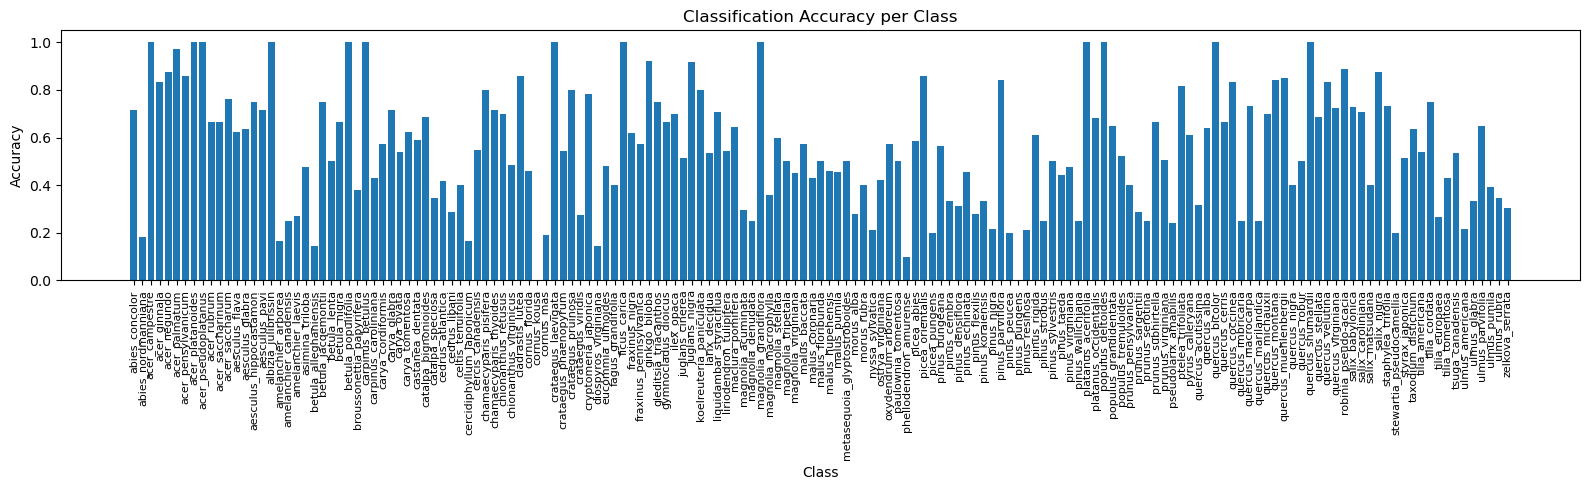

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.bar(class_names, acc_per_class.values)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy per Class')
plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

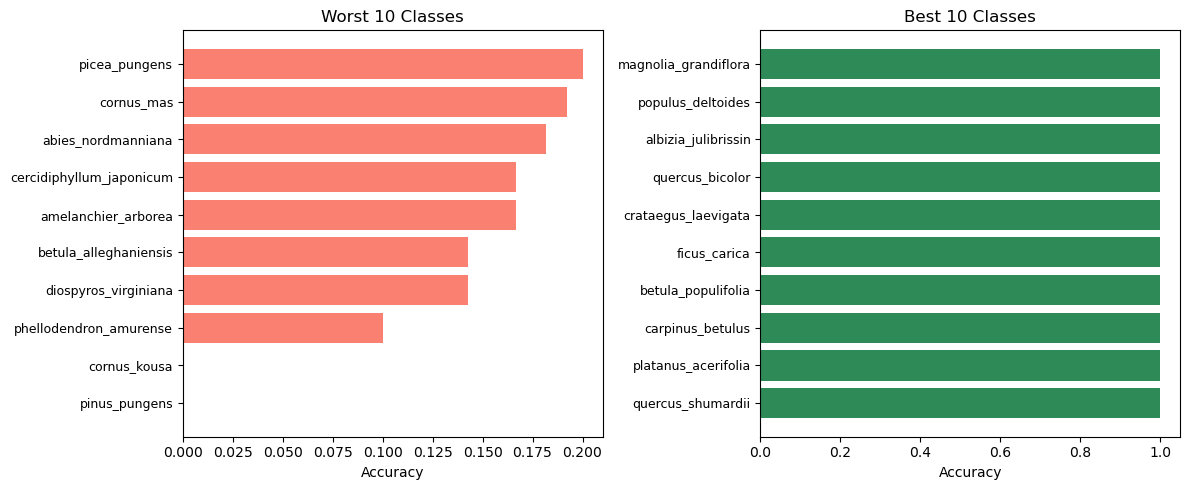

In [35]:
# Top/bottom 10 classes
worst_k = acc_per_class.sort_values()[:10]
best_k = acc_per_class.sort_values(ascending=False)[:10]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.barh([idx_to_label[idx] for idx in worst_k.index], worst_k.values, color='salmon')
plt.xlabel('Accuracy')
plt.title('Worst 10 Classes')
plt.yticks(fontsize=9)

plt.subplot(1,2,2)
plt.barh([idx_to_label[idx] for idx in best_k.index], best_k.values, color='seagreen')
plt.xlabel('Accuracy')
plt.title('Best 10 Classes')
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

#### 代码解释:

##### pd.DataFrame({'image': test_df['image'], 'label': predicted_labels}): 创建一个新的Pandas DataFrame，包含测试集图像的文件名和对应的预测标签。
##### submission_csv_path = os.path.join(BASE_DIR, 'submission.csv'): 定义提交文件的保存路径，通常是项目根目录下的submission.csv。
##### submission_df.to_csv(submission_csv_path, index=False): 将DataFrame保存为CSV文件。index=False表示不写入DataFrame的索引列。